In [1]:
import pandas as pd

# Load the CSV
df = pd.read_csv("MAGNDATA_Commensurate_WithVectors.csv")

# Clean and normalize the vector strings
df["Propagation Vector"] = df["Propagation Vector"].astype(str).str.replace(" ", "").str.strip()

# Map 0,0,0 → "zero", others → "nonzero"
df["k_vector_label"] = df["Propagation Vector"].apply(lambda x: "zero" if x in ["0,0,0", "(0,0,0)"] else "nonzero")

# Save updated file
df.to_csv("MAGNDATA_WithBinaryKVector.csv", index=False)
print("✅ Saved as 'MAGNDATA_WithBinaryKVector.csv'")


✅ Saved as 'MAGNDATA_WithBinaryKVector.csv'


In [2]:
import pandas as pd
import re

# Load MAGNDATA with binary k-vector labels
magndata_df = pd.read_csv("MAGNDATA_WithBinaryKVector.csv")

# Load Materials Project data
mp_df = pd.read_csv("All Data Imported.csv")

# === Extract formula from MAGNDATA ===
# Assume "Full Label" or similar column contains the formula, e.g., "0.123Fe2O3"
# If your formula column is already clean, skip this part
if "formula" not in magndata_df.columns:
    magndata_df["formula"] = magndata_df["Full Label"].str.extract(r"\d*\.\d+(.*)")[0].str.strip()

# Standardize formatting
magndata_df["formula"] = magndata_df["formula"].str.strip()
mp_df["formula"] = mp_df["formula"].str.strip()

# === Merge only matching formulas ===
merged_df = pd.merge(magndata_df, mp_df, on="formula", how="inner")

# Save the result
merged_df.to_csv("MAGNDATA_WithBinaryKVector_Merged.csv", index=False)
print("✅ Saved merged file as 'MAGNDATA_WithBinaryKVector_Merged.csv'")


✅ Saved merged file as 'MAGNDATA_WithBinaryKVector_Merged.csv'


Fitting 6 folds for each of 144 candidates, totalling 864 fits

✅ Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

🔍 Cross-validation mean F1_macro scores per param set:
Score: 0.7694 → Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.7670 → Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Score: 0.7661 → Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Score: 0.7608 → Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Score: 0.7591 → Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Score: 0.7651 → Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Score: 0.7691 → Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Score: 0.763

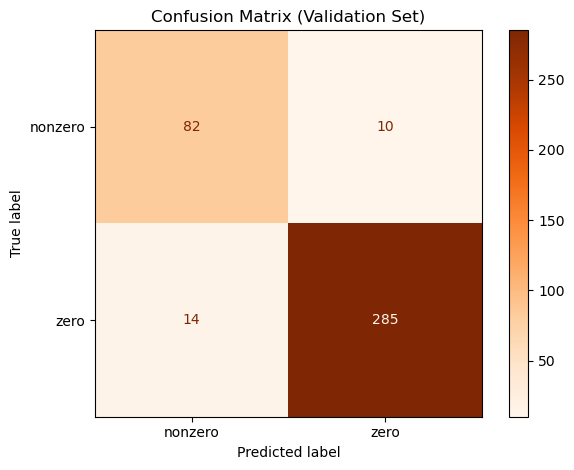


🧪 Test Report:
              precision    recall  f1-score   support

     nonzero       0.80      0.80      0.80        41
        zero       0.94      0.94      0.94       133

    accuracy                           0.91       174
   macro avg       0.87      0.87      0.87       174
weighted avg       0.91      0.91      0.91       174



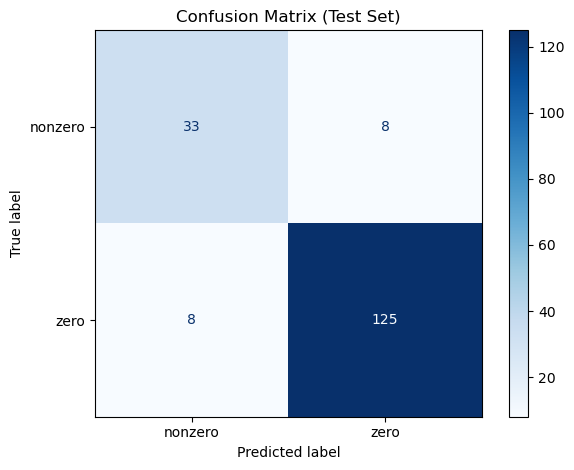

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

# === 1. Load dataset ===
df = pd.read_csv("MAGNDATA_WithBinaryKVector_Merged.csv")

# === 2. Parse elements ===
def parse_elements(val):
    if pd.isna(val): return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]
df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str): return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"
df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Numerical features and drop missing ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["k_vector_label"])

# === 5. Encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. Encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["k_vector_label"])

# === 9. Split (90/10) and the 90 such that 75% of them are for training with 6-fold CV and 25% are for the seperate Validation set ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 10. Setup GridSearchCV ===
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [6, 10, 15,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# === 11. Fit model ===
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === Print mean CV scores ===
cv_results = grid_search.cv_results_
mean_scores = cv_results['mean_test_score']
params = cv_results['params']

print("🔍 Cross-validation mean F1_macro scores per param set:")
for score, param in zip(mean_scores, params):
    print(f"Score: {score:.4f} → Params: {param}")

# === 12. Validation evaluation ===
y_pred_val = best_rf.predict(X_val)
print("\n📊 Validation Report:")
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val, display_labels=le.classes_, cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# === 13. Test evaluation ===
y_pred_test = best_rf.predict(X_test)
print("\n🧪 Test Report:")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=le.classes_, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


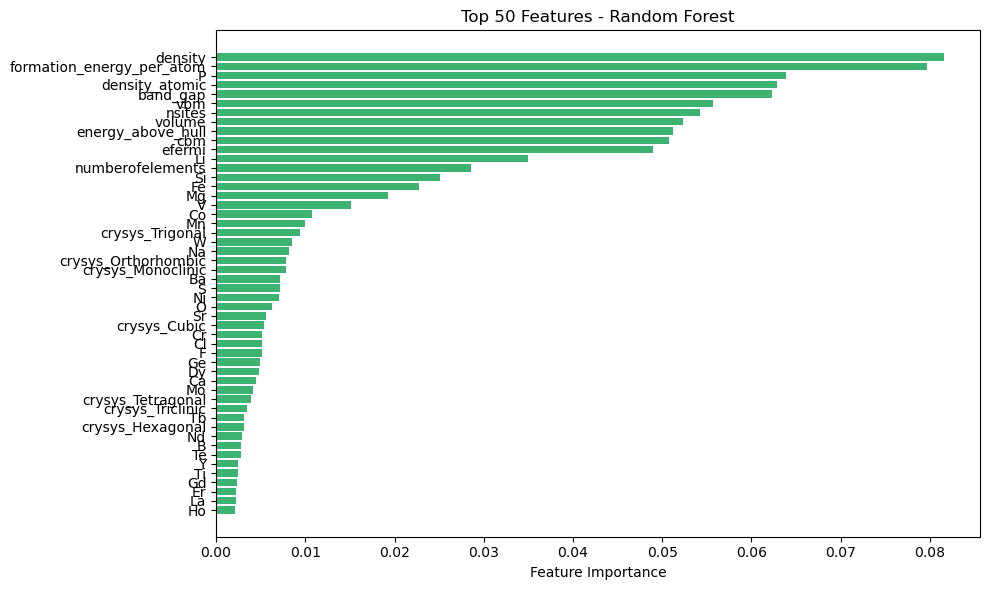

In [10]:
importances = best_rf.feature_importances_
feature_names = X.columns

# Create a DataFrame of feature importances
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)


top_n = 50
feat_df_top = feat_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_df_top["Feature"][::-1], feat_df_top["Importance"][::-1], color="mediumseagreen")
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Features - Random Forest")
plt.tight_layout()
plt.show()


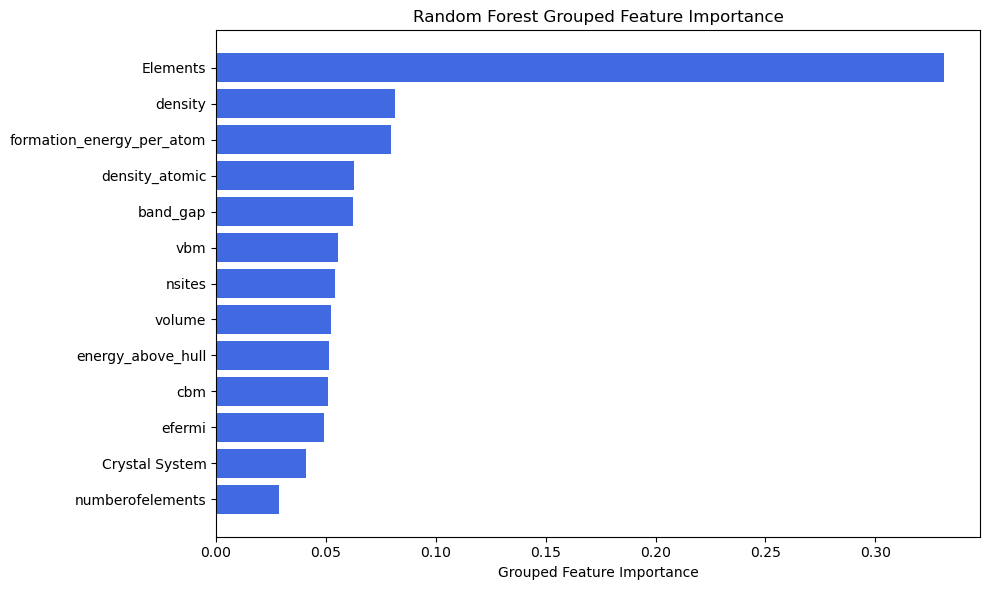

In [11]:
# === 1. Collect importances ===
importances = best_rf.feature_importances_
feature_names = X.columns

# === 2. Tag feature groups ===
group_labels = []
for feat in feature_names:
    if feat in numerical_features:
        group_labels.append(feat)  # keep numerical expanded
    elif feat in mlb.classes_:
        group_labels.append("Elements")
    elif feat.startswith("crysys_"):
        group_labels.append("Crystal System")
    else:
        group_labels.append("Other")

# === 3. Build DataFrame and group ===
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances,
    "Group": group_labels
})

# === 4. Sum grouped importances (except numericals kept expanded) ===
# Keep only numericals + grouped totals
numerical_df = feat_df[feat_df["Group"].isin(numerical_features)]
grouped_df = feat_df[~feat_df["Group"].isin(numerical_features)].groupby("Group", as_index=False)["Importance"].sum()

# Combine
final_df = pd.concat([numerical_df[["Feature", "Importance"]].rename(columns={"Feature": "Group"}), grouped_df])
final_df = final_df.sort_values("Importance", ascending=False)

# === 5. Plot ===
plt.figure(figsize=(10, 6))
plt.barh(final_df["Group"][::-1], final_df["Importance"][::-1], color="royalblue")
plt.xlabel("Grouped Feature Importance")
plt.title("Random Forest Grouped Feature Importance")
plt.tight_layout()
plt.show()


In [3]:
# Apply our best RF classifier to All Data Imported.csv after removing the seen data in the merged file

import pandas as pd

# === 1. Load both datasets ===
all_data = pd.read_csv("All Data Imported.csv")
magndata = pd.read_csv("MAGNDATA_WithBinaryKVector_Merged.csv")

# === 2. Standardize formula columns ===
all_data["formula"] = all_data["formula"].str.strip()
magndata["formula"] = magndata["formula"].str.strip()

# === 3. Remove materials already in MAGNDATA ===
filtered_df = all_data[~all_data["formula"].isin(magndata["formula"])].copy()

print(f"✅ Filtered dataset has {len(filtered_df)} materials after removing seen ones.")

# === 4. Continue with prediction as before ===
# Reuse parse_elements and extract_crystal_system functions
def parse_elements(val):
    if pd.isna(val): return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str): return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

# === 5. Feature Engineering ===
filtered_df["elements"] = filtered_df["elements"].apply(parse_elements)
filtered_df["crystal_system"] = filtered_df["symmetry"].apply(extract_crystal_system)

# Drop rows with missing required numerical values
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
filtered_df = filtered_df.dropna(subset=numerical_features)

# One-hot encode elements and crystal system
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(filtered_df["elements"]), columns=mlb.classes_)
crystal_df = pd.get_dummies(filtered_df["crystal_system"], prefix="crysys")

# Combine into feature matrix
X_filtered = pd.concat([
    filtered_df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# Align feature set with training feature space
missing_cols = [col for col in X.columns if col not in X_filtered.columns]
for col in missing_cols:
    X_filtered[col] = 0
X_filtered = X_filtered[X.columns]  # match training feature order

# Predict using the trained classifier
y_pred_filtered = best_rf.predict(X_filtered)
predicted_labels = le.inverse_transform(y_pred_filtered)

# Save results
filtered_df["Predicted Propagation Vector"] = predicted_labels
filtered_df.to_csv("Unseen_Data_With_Predicted_Propagation_Vector Random Forest.csv", index=False)
print("✅ Saved predictions to 'Unseen_Data_With_Predicted_Propagation_Vector Random Forest.csv'")



✅ Filtered dataset has 153067 materials after removing seen ones.
✅ Saved predictions to 'Unseen_Data_With_Predicted_Propagation_Vector Random Forest.csv'


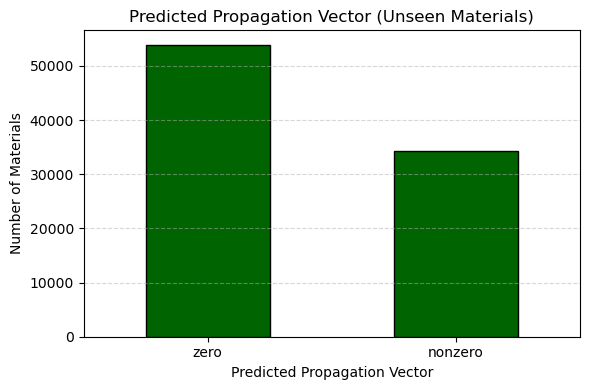

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the unseen predictions
df = pd.read_csv("Unseen_Data_With_Predicted_Propagation_Vector.csv")

# Count occurrences
counts = df["Predicted Propagation Vector"].value_counts()

# Plot histogram
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color='darkgreen', edgecolor='black')
plt.title("Predicted Propagation Vector (Unseen Materials)")
plt.xlabel("Predicted Propagation Vector")
plt.ylabel("Number of Materials")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


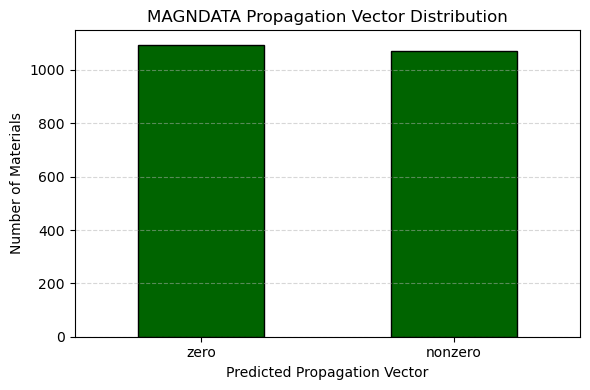

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the unseen predictions
df = pd.read_csv("MAGNDATA_WithBinaryKVector.csv")

# Count occurrences
counts = df["k_vector_label"].value_counts()

# Plot histogram
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color='darkgreen', edgecolor='black')
plt.title("MAGNDATA Propagation Vector Distribution")
plt.xlabel("Predicted Propagation Vector")
plt.ylabel("Number of Materials")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [4]:
import pandas as pd

# Load the unseen prediction file
df = pd.read_csv("Unseen_Data_With_Predicted_Propagation_Vector Random Forest.csv")

# Filter: predicted nonzero and ordering FM
fm_nonzero_df = df[
    (df["Predicted Propagation Vector"] == "nonzero") &
    (df["ordering"] == "FM")
]

# Show result summary
print(f"🔍 Number of materials with Predicted nonzero k-vector and FM ordering: {len(fm_nonzero_df)}")
print(fm_nonzero_df[["formula", "ordering", "Predicted Propagation Vector"]].head())

# Save to new CSV
fm_nonzero_df.to_csv("Unseen_FM_with_nonzero_k_vector_prediction Random Forest.csv", index=False)
print("✅ Saved to 'Unseen_FM_with_nonzero_k_vector_prediction Random Forest.csv'")


🔍 Number of materials with Predicted nonzero k-vector and FM ordering: 12609
               formula ordering Predicted Propagation Vector
468   Al3Tl4Fe(As2O7)4       FM                      nonzero
1124        Ba2MgNiWO6       FM                      nonzero
1140       Ba2NaMn3F11       FM                      nonzero
1239         Ba2GdNbO6       FM                      nonzero
1240         Ba2GdNbO6       FM                      nonzero
✅ Saved to 'Unseen_FM_with_nonzero_k_vector_prediction Random Forest.csv'


These are the materials that the propagation vector classifiers predict to be non-Ferromagnetic (i.e. nonzero propagation vector), and they have FM label on Materials Project.